In [1]:
import os
import numpy as np
import importlib

import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

from utils.common import plot_hist_seaborn, plot_ROC_curve, read_annotations, load_config
from utils.evaluation import evaluate_multiclass, metric_ood, compute_oscr
from data.dataset import ImageDataset
from models.models import Simple_CNN

In [2]:
def get_feature(model, dataloader, config, device):
    model.eval()
    Loss = importlib.import_module('loss.' + config.loss)
    criterion = getattr(Loss, config.loss)(config).to(device)
    with torch.no_grad():
        features = []
        labels =[]
        probs=[]
        for i, batch in enumerate(tqdm(dataloader, desc='Processing')):
            input_img_batch, label_batch, _ = batch 
            input_img = input_img_batch.reshape((-1, 3, input_img_batch.size(-2), input_img_batch.size(-1))).to(device)
            label = label_batch.reshape((-1)).to(device)
            prob, feature = model(input_img, data='dct')
            prob, _ = criterion(feature, prob)

            if i == 0:
                probs = prob
                gt_labels = label
                features = feature
            else:
                probs = torch.cat([probs, prob], dim=0)
                gt_labels = torch.cat([gt_labels, label])
                features=torch.cat(([features, feature]))

    features = features.cpu().numpy()
    probs = probs.cpu().numpy()
    labels = gt_labels.cpu().numpy()
        
    return features, labels, probs

In [3]:
def calculate_open_set_result(_labels_k, _labels_u, _pred_k, _pred_u, known_feature, unknown_feature, known_classes, unknown_classes, save_dir):
    
    x1, x2 = np.max(_pred_k, axis=1), np.max(_pred_u, axis=1)
    out_results = metric_ood(x1, x2)['Bas'] # check
    _oscr_socre = compute_oscr(_pred_k, _pred_u, _labels_k)
    unknown_perf = round(out_results['AUROC'], 2)

    print("AUC, OSCR : {:.2f} {:.2f}".format(unknown_perf, _oscr_socre*100))

    # plot confidence histogram and ROC curve
    os.makedirs(save_dir, exist_ok=True)
    plot_hist_seaborn(x1, x2, save_path = os.path.join(save_dir,'hist.png'))
    plot_ROC_curve(out_results, save_path = os.path.join(save_dir,'roc.png'))
    
    # print detailed results for each unknown class
    for i, label_u in enumerate(set(_labels_u)):
        pred_u = _pred_u[_labels_u==label_u]
        x1, x2 = np.max(_pred_k, axis=1), np.max(pred_u, axis=1)
        pred = np.argmax(pred_u, axis=1)
        pred_labels = list(set(pred))
        pred_nums = [np.sum(pred==p) for p in pred_labels]
        result = metric_ood(x1, x2, verbose=False)['Bas']
        print("{}\t \t mostly pred class: {}\t \t average score: {}\t AUROC (%): {:.2f}".format(unknown_classes[i], 
                                                                                 known_classes[pred_labels[np.argmax(pred_nums)]],
                                                                                 np.mean(x2), result['AUROC']))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = load_config('configs.{}'.format('progressive'))

# load model
model_path = '/mnt/workspace/POSE/dataset/models/progressive/0612/POSE_seed0/model_24_test91.75_acc_AUC_80.8_OSCR_77.09646012396702.pth'
model = Simple_CNN(class_num=11, out_feature_result=True)
pretrained_dict = torch.load(model_path, map_location='cpu')['state_dict']
model.load_state_dict(pretrained_dict)
model = model.to(device)

In [5]:
# load test data
script_dir = os.getcwd()
print(script_dir)
test_data_path = '/mnt/workspace/POSE/dataset/annotations/test_list.txt'
close_set = ImageDataset(read_annotations(script_dir, test_data_path), config, balance=False, test_mode=True)
close_loader = DataLoader(
    dataset=close_set,
    num_workers=config.num_workers,
    batch_size=config.batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)

#  get features of known data
known_feature, known_label, known_prob  = get_feature(model, close_loader, config, device)
pred_labels = np.argmax(known_prob, axis=1)
results = evaluate_multiclass(known_label, pred_labels)
print('closed-set accuracy', round(results['acc'], 4)*100)

/mnt/workspace/POSE


Processing:   0%|          | 0/1375 [00:00<?, ?it/s]/mnt/workspace/POSE/loss/Softmax.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)  # 计算模型输出的softmax概率分布
Processing: 100%|██████████| 1375/1375 [00:36<00:00, 37.97it/s]

closed-set accuracy 37.82


Processing:   0%|          | 0/2750 [00:00<?, ?it/s]/mnt/workspace/POSE/loss/Softmax.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)  # 计算模型输出的softmax概率分布
Processing: 100%|██████████| 2750/2750 [01:17<00:00, 35.63it/s]


       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas     7.318 56.813 57.820 47.437 71.036
AUC, OSCR : 56.81 30.33


/mnt/workspace/POSE/utils/common.py:111: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)
/mnt/workspace/POSE/utils/common.py:111: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d, shade=True, alpha=.3, label=legend)


celeba/SNGAN	 	 mostly pred class: Faces_HQ_styleGAN	 	 average score: 0.1111670657992363	 AUROC (%): 65.53
celeba/AttGAN	 	 mostly pred class: Faces_HQ_styleGAN	 	 average score: 0.11255795508623123	 AUROC (%): 73.02
celeba/starGAN	 	 mostly pred class: Faces_HQ_styleGAN	 	 average score: 0.11116521805524826	 AUROC (%): 67.11
Faces_HQ/styleGAN2	 	 mostly pred class: Faces_HQ_styleGAN	 	 average score: 0.11121439933776855	 AUROC (%): 30.74
Faces_HQ/styleGAN3_r	 	 mostly pred class: Faces_HQ_styleGAN	 	 average score: 0.11117719113826752	 AUROC (%): 57.63
Faces_HQ/styleGAN3_t	 	 mostly pred class: Faces_HQ_styleGAN	 	 average score: 0.11117904633283615	 AUROC (%): 55.92
celeba/DisBetaVAE	 	 mostly pred class: celeba_VanillaVAE	 	 average score: 0.8121002316474915	 AUROC (%): 17.32
celeba/InfoVAE	 	 mostly pred class: celeba_BetaVAE	 	 average score: 0.5713279247283936	 AUROC (%): 19.62
celeba/glow	 	 mostly pred class: Faces_HQ_styleGAN	 	 average score: 0.11118723452091217	 AUROC (%): 

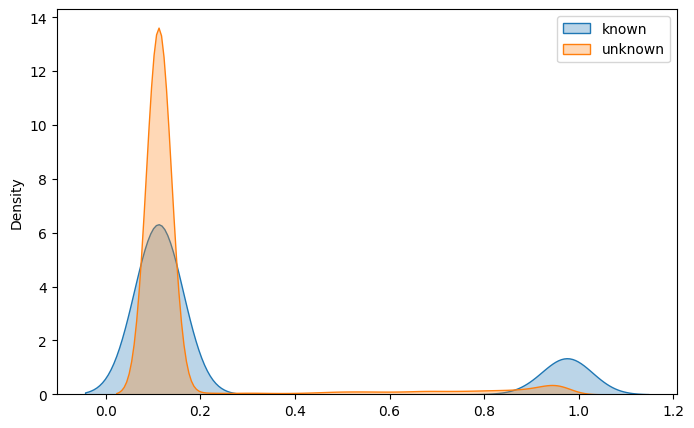

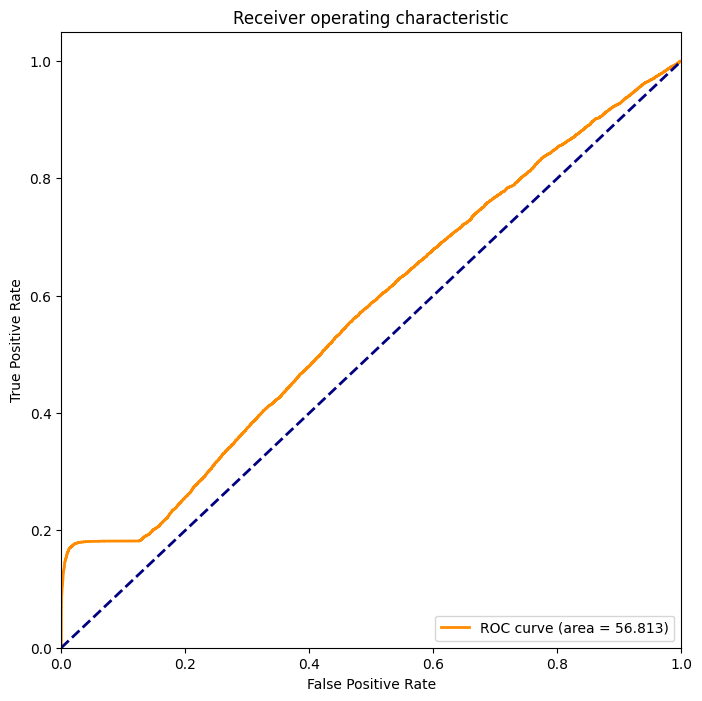

In [6]:
# load out data
out_data_path = '/mnt/workspace/POSE/dataset/annotations/test_out_list.txt'
out_set = ImageDataset(read_annotations(script_dir, out_data_path), config, balance=False, test_mode=True)
out_loader = DataLoader(
    dataset=out_set,
    num_workers=config.num_workers,
    batch_size=config.batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)

# get features of out data
out_feature, out_label, out_prob  = get_feature(model, out_loader, config, device)
known_classes = ['real', 'celeba_ProGAN', 'celeba_MMDGAN', 'Faces_HQ_ProGAN', 'Faces_HQ_styleGAN', 'celeba_VanillaVAE', 'celeba_BetaVAE', 'lsun_bedroom_ADM', 'lsun_bedroom_DDPM', 'stable_diffusion_v15', 'stable_diffusion_v21']
unknown_classes =  ['celeba/SNGAN', 'celeba/AttGAN', 'celeba/starGAN', 'Faces_HQ/styleGAN2', 'Faces_HQ/styleGAN3_r','Faces_HQ/styleGAN3_t', 'celeba/DisBetaVAE', 'celeba/InfoVAE', 'celeba/glow', 'celeba/ResFlow','lsun_bedroom/LDM', 'lsun_bedroom/PNDM', 'celeba/Styleformer', 'celeba/TransGAN', 'ffhq/gansformer', 'ffhq/StyleSwin', 'stable_diffusion_xl', 'midjourney_kaggle', 'T2I/glide', 'T2I/dalle-mini',  'T2I/dalle_2', 'T2I/dalle_3']  
calculate_open_set_result(known_label, out_label, known_prob, out_prob, known_feature, out_feature, known_classes, unknown_classes, './results/unseen_seed')